In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

In [2]:
mesh=40
# y_val= [A_TAT,V_TAT]
y_val = torch.tensor([134,134])

In [3]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_13/xlabels.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_'+str(mesh)+'/X.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

     CV_ventricles  k_ventricles    k_FEC  CV_atria   k_atria     k_BB
0         0.606444      0.442714  5.53288  0.317814  0.376440  1.35358
1         0.518476      0.304389  6.83032  0.628421  0.237364  1.25791
2         0.641101      0.239081  5.82181  1.020680  0.437033  5.30559
3         0.750099      0.373713  4.49537  0.526532  0.444927  2.07317
4         0.689263      0.388615  2.34609  0.556797  0.477035  2.36587
..             ...           ...      ...       ...       ...      ...
115       0.545148      0.260282  1.41140  0.982380  0.242211  2.02864
116       0.407284      0.272427  1.55631  0.353259  0.340049  1.65963
117       0.796166      0.465371  7.16628  0.539272  0.228129  1.68568
118       0.752534      0.476168  3.40841  0.386740  0.264407  5.40274
119       0.687991      0.318799  6.32706  0.767307  0.234231  4.38626

[120 rows x 6 columns]


In [4]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_13/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_'+str(mesh)+'/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)

        A_TAT     V_TAT
0    326.3430  100.5180
1    183.9530  130.7160
2     78.6365  115.3240
3    174.7200   86.9669
4    159.2430   95.3313
..        ...       ...
115  107.5570  140.7120
116  284.2610  182.8520
117  205.9150   73.8898
118  239.8420   80.7692
119  125.1910   97.1398

[120 rows x 2 columns]


# Emulator

In [5]:
y_all.max()

A_TAT    352.723
V_TAT    200.881
dtype: float64

In [6]:
input_masked = X_all.copy()

In [7]:
y_all

,A_TAT,V_TAT
0,326.3430,100.5180
1,183.9530,130.7160
2,78.6365,115.3240
3,174.7200,86.9669
4,159.2430,95.3313
...,...,...
115,107.5570,140.7120
116,284.2610,182.8520
117,205.9150,73.8898
118,239.8420,80.7692


In [8]:
y_train = torch.tensor(y_all.values)
x_train = torch.tensor(X_all[0:y_all.shape[0]].values)

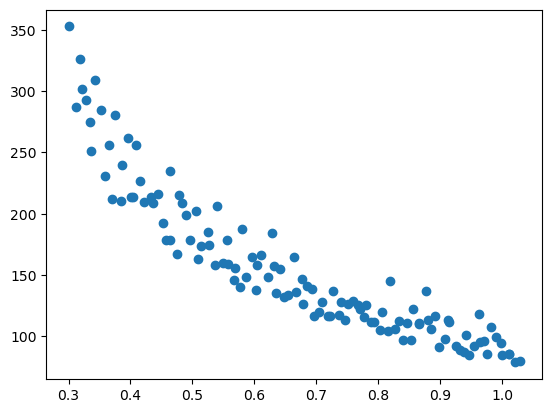

In [9]:
plt.plot(x_train[:,3],y_train[:,0],'o')

In [10]:
y_train

tensor([[326.3430, 100.5180],
        [183.9530, 130.7160],
        [ 78.6365, 115.3240],
        [174.7200,  86.9669],
        [159.2430,  95.3313],
        [159.4960,  85.7816],
        [111.5320, 160.8760],
        [128.2950, 126.4680],
        [ 85.2694,  95.2810],
        [ 96.5890, 133.9790],
        [122.4770, 101.4700],
        [209.7640, 123.8980],
        [ 96.7988, 122.7850],
        [119.8950, 164.1450],
        [116.8980, 114.6310],
        [192.3800,  90.0702],
        [164.9690,  84.7386],
        [126.4440, 105.3290],
        [208.7870, 200.8810],
        [110.6070,  84.1817],
        [ 85.8296,  94.4645],
        [ 94.2734, 133.3010],
        [308.7260, 152.8160],
        [185.4290, 141.9500],
        [ 87.5541, 118.7400],
        [292.7550, 122.8820],
        [111.8240, 163.7690],
        [ 79.7282, 104.8940],
        [118.5210,  93.8477],
        [135.1400, 150.6880],
        [133.8990, 105.4380],
        [213.3040, 112.7240],
        [105.2660,  88.9114],
        [1

In [11]:
x_train.shape

torch.Size([120, 6])

In [12]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1


In [13]:
nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[0.382351, 0.799717]
[0.201679, 0.499831]
[1.24091, 8.38479]
[0.300623, 1.02851]
[0.200837, 0.497599]
[1.01838, 5.67135]


In [14]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_14526/2553582652.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [15]:
data1.shape

torch.Size([14336, 6])

In [16]:
Si = []
nMod = y_all.shape[1]
nDim = input_masked.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

                        ST   ST_conf
(CV_ventricles,)  0.000049  0.000009
(k_ventricles,)   0.000041  0.000008
(k_FEC,)          0.000225  0.000054
(CV_atria,)       0.936569  0.058021
(k_atria,)        0.026904  0.002967
(k_BB,)           0.040346  0.004641
                        S1   S1_conf
(CV_ventricles,)  0.000024  0.000601
(k_ventricles,)   0.000029  0.000543
(k_FEC,)          0.000038  0.001077
(CV_atria,)       0.930694  0.074604
(k_atria,)        0.022923  0.012580
(k_BB,)           0.035365  0.019058
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                        ST   ST_conf
(CV_ventricles,)  0.857318  0.055386
(k_ventricles,)   0.133757  0.010708
(k_FEC,)          0.015835  0.001727
(CV_atria,)       0.000165  0.000044
(k_atria,)        0.000614  0.000172
(k_BB,)           0.000050  0.000008
                        S1   S1_conf
(CV_ventricles,)  0.850682  0.071311
(k_ventricles,)   0.127791  0.027948
(k_FEC,)          0.013229  0.009680
(CV_atria,)      -0.000148

In [17]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


In [18]:
x_labels.values.squeeze().tolist()

['CV_ventricles', 'k_ventricles', 'k_FEC', 'CV_atria', 'k_atria', 'k_BB']

In [19]:
y_all.columns.tolist()

['A_TAT', 'V_TAT']

In [20]:
['PCa_b',
 'Tref',
 'perm50',
 'CV_ventricles',
 'a_ventricles',
 'EDP_lv',
 'EDP_rv',
 'Rsys',
 'Rpulm']

['PCa_b',
 'Tref',
 'perm50',
 'CV_ventricles',
 'a_ventricles',
 'EDP_lv',
 'EDP_rv',
 'Rsys',
 'Rpulm']

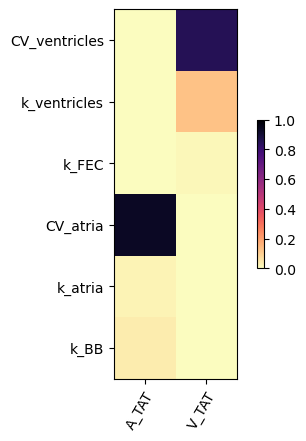

In [21]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_xticks(np.arange(len(outputs)),labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

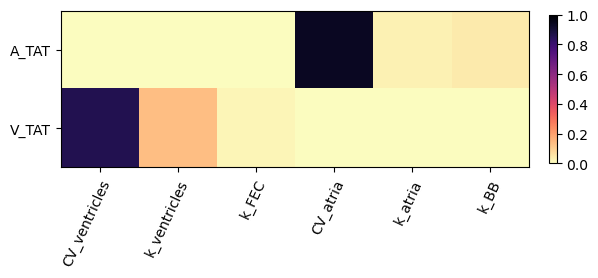

In [22]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=65, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [23]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [24]:
boundsMaxMin

[[0.382351, 0.799717],
 [0.201679, 0.499831],
 [1.24091, 8.38479],
 [0.300623, 1.02851],
 [0.200837, 0.497599],
 [1.01838, 5.67135]]

In [25]:
boundsMaxMin=np.array(boundsMaxMin)

In [26]:
np.array(boundsMaxMin)[[0,3],0]

array([0.382351, 0.300623])

In [27]:
np.array(boundsMaxMin)[[0,3],1]

array([0.799717, 1.02851 ])

In [28]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[[0,3],0]<theta).all() and (theta<np.array(boundsMaxMin)[[0,3],1]).all():

        return 0.0
    return -np.inf

In [29]:
def log_likelihood(x,emulator,y_val,obs_error,fix_loc):
    #x=torch.tensor(x)[None]
    test=fix_loc.copy()
    test[:,0]=x[0]
    test[:,3]=x[1]
    
    with gpytorch.settings.fast_pred_var(): #This line makes it fast!
        ll =np.sum((emulator.ensemble_log_likelihood_obs_error(torch.tensor(test),y_val[None],obs_error)).detach().numpy())
    return ll

In [30]:
def log_prob(theta, emulator,y_val,obs_error,fix_loc):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(theta,emulator, y_val,obs_error,fix_loc)

In [31]:
import emcee

In [32]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2
ndim = 2
nwalkers = 8
p0 = np.random.uniform(0,1,(nwalkers,ndim))*(np.array(boundsMaxMin)[[0,3],1]-np.array(boundsMaxMin)[[0,3],0])+np.array(boundsMaxMin)[[0,3],0]
#y_val = torch.tensor([80,134])
obs_error=((y_val*0.05))**2

In [33]:
y_val+2*((y_val*0.05))

tensor([147.4000, 147.4000])

In [34]:
boundsMaxMin

array([[0.382351, 0.799717],
       [0.201679, 0.499831],
       [1.24091 , 8.38479 ],
       [0.300623, 1.02851 ],
       [0.200837, 0.497599],
       [1.01838 , 5.67135 ]])

In [35]:
obs_error

tensor([44.8900, 44.8900])

In [36]:
fix_loc=centre[None]

In [37]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val,obs_error,fix_loc])



In [38]:
sampler.run_mcmc(p0, 40000,progress=True)

100%|████████████████████████████████████| 40000/40000 [06:16<00:00, 106.13it/s]


State([[0.53187986 0.66998767]
 [0.52599895 0.70717152]
 [0.50453257 0.7059101 ]
 [0.49416398 0.67496497]
 [0.46133365 0.62426147]
 [0.51451708 0.69561859]
 [0.52044037 0.68760997]
 [0.52429999 0.6592265 ]], log_prob=[-6.79825163 -7.22580051 -6.46329117 -5.70960045 -7.39500761 -6.43449306
 -6.47695589 -6.42376137], blobs=None, random_state=('MT19937', array([  82456605, 2509704237, 4279691946, 1019379233, 1643655379,
       2205400460,  769907514,  871870074,  580651495, 2487449366,
       2450111437, 3657606367, 3895386988, 4253251402,  244873800,
       1612616037, 3304072374, 1616007421, 2616674004,  220670885,
       3242319871, 4218320890, 2244968275, 4248850795, 2909834670,
       2222338342, 3616254119, 2618344692,  522539976, 4224331378,
       2929307533, 2531450196,  699029242, 2507503305, 1705307311,
       4276668438,   74617230, 2531524105, 1682796923, 1951103627,
       1149315194, 1810781839, 3105384270, 3271947311,  404287688,
       2141399517, 3791264223,   19398748, 

In [39]:
flat_samples = sampler.get_chain(discard=20000, thin=10, flat=True)
print(flat_samples.shape)

(16000, 2)


In [40]:
boundsMaxMin

array([[0.382351, 0.799717],
       [0.201679, 0.499831],
       [1.24091 , 8.38479 ],
       [0.300623, 1.02851 ],
       [0.200837, 0.497599],
       [1.01838 , 5.67135 ]])

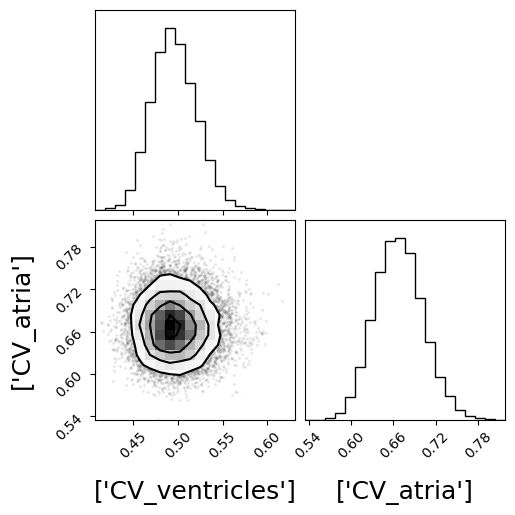

In [41]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values[[0,3]], label_kwargs=dict(fontsize=18)
);

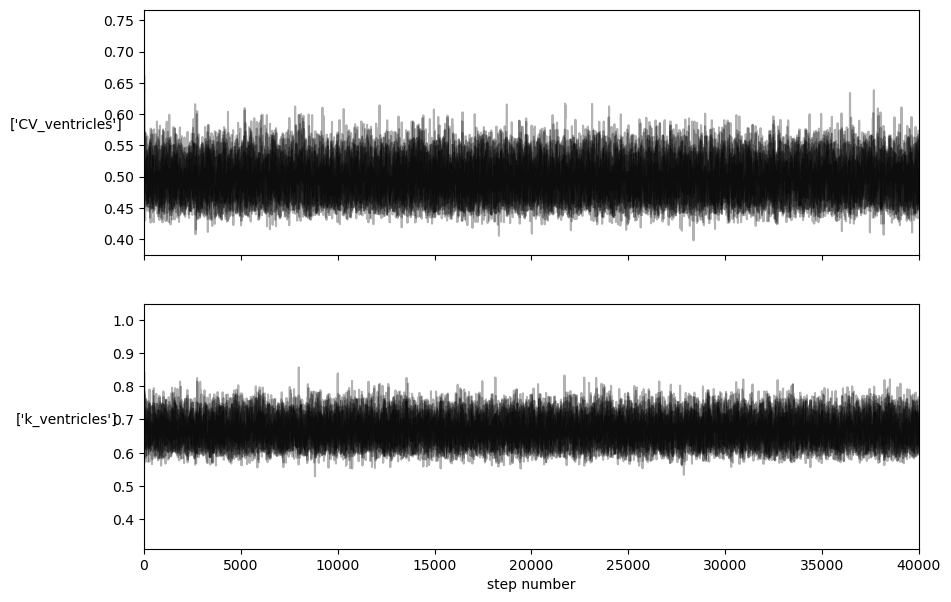

In [42]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [43]:
test=torch.tensor(centre)
test[0]=flat_samples.mean(axis=0)[0]
test[3]=flat_samples.mean(axis=0)[1]
emulator.predict(test[None])

tensor([[133.2245, 132.9941]], grad_fn=<PermuteBackward0>)

In [44]:
flat_samples.mean(axis=0)

array([0.49629201, 0.66833789])

In [45]:
flat_samples.std(axis=0)

array([0.02517136, 0.03446175])

In [46]:
flat_samples.mean(axis=0)-flat_samples.std(axis=0)

array([0.47112066, 0.63387615])

In [47]:
flat_samples.mean(axis=0)+flat_samples.std(axis=0)

array([0.52146337, 0.70279964])

In [48]:
boundsMaxMin.T

array([[0.382351, 0.201679, 1.24091 , 0.300623, 0.200837, 1.01838 ],
       [0.799717, 0.499831, 8.38479 , 1.02851 , 0.497599, 5.67135 ]])